# Исследование бизнес-показателей приложения Procrastinate+

# Описание проекта
Маркетинговый отдел развлекательного приложения Procrastinate Pro+ заказал провести расследование. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Моя задача — разобраться в причинах и помочь компании выйти в плюс.
Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
лог сервера с данными об их посещениях,
выгрузка их покупок за этот период,
рекламные расходы.

Мне предстоит изучить:

- откуда приходят пользователи и какими устройствами они пользуются;
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент;
- когда расходы на привлечение клиента окупаются;
- какие факторы мешают привлечению клиентов.


Мое исследование пройдет в 6 этапов:
- ознакомление с данными и их предобработка;
- подготовление функций для будущих расчетов и визуализаций;
- исследовательский анализ данных;
- расчет маркетинговых показателей;
- оценка окупаемости рекламы при помощи расчетов и графиков;
- итоговые выводы.

## Ознакомление с данными и подготовка

Загрузим данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visits_info_short.csv);
- заказы: `/datasets/orders_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders_info_short.csv);
- расходы: `/datasets/costs_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/costs_info_short.csv).

In [1]:
# импортируем необходимые для исследования библиотеки
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

pd.set_option('display.max_colwidth', None)

Далее выгрузим датасеты, назвав их visits, orders и ad_costs для удобства.

In [2]:
# выгрузим датасеты с удобными для работы переменными
try:
    visits, orders, ad_costs = (
    pd.read_csv('/datasets/visits_info_short.csv'),  # визиты
    pd.read_csv('/datasets/orders_info_short.csv'),  # заказы
    pd.read_csv('/datasets/costs_info_short.csv'))  # расходы
except:
    visits, orders, ad_costs = (
    pd.read_csv('https://code.s3.yandex.net/datasets/visits_info_short.csv'),  # визиты
    pd.read_csv('https://code.s3.yandex.net/datasets/orders_info_short.csv'),  # заказы
    pd.read_csv('https://code.s3.yandex.net/datasets/costs_info_short.csv'),  # расходы
)
  

Отобразим первые 5 строчек каждого датасета для проверки правильной выгрузки.

In [3]:
display(visits.head())

display(orders.head())

ad_costs.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


Данные выгрузились корректно. Далее проведем предобработку.

### Предобработка данных

Просмотрим основную информацию о датасетах. Проверим на пропуски и соответствие типам данных.

In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [6]:
ad_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Пропуски отсутствуют во всех представленных датасетах, однако нужно привести названия всех столбцов к единому регистиру и опрятному виду, а также преобразовать столбцы с данными о времени в формат datetime.

In [7]:
# для приведения к красивому названию столбцов 
# нам достаточно заменить пробелы на нижнее подчеркивание
# и привести к нижнемку регистру, напишем функци для этого

def unify_col(data):
    data.columns=[col.replace(' ','_').lower() for col in data.columns]
    return data

Применим функцию к нашим датасетам и перепроверим названия.

In [8]:
visits = unify_col(visits)

visits.columns

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')

In [9]:
orders = unify_col(orders)

orders.columns

Index(['user_id', 'event_dt', 'revenue'], dtype='object')

In [10]:
ad_costs = unify_col(ad_costs)

ad_costs.columns

Index(['dt', 'channel', 'costs'], dtype='object')

Названия столбцов приведены к общему виду, далее преобразуем тип данных, связанный с датой и временем, к datetime.

In [11]:
visits['session_start'] = pd.to_datetime(visits['session_start'])

visits['session_end'] = pd.to_datetime(visits['session_end'])

orders['event_dt'] = pd.to_datetime(orders['event_dt'])

ad_costs['dt'] = pd.to_datetime(ad_costs['dt']).dt.date

In [12]:
# добавим функцию для первичного анализа датафрейма

def analyze_data(data):
    # Описание статистики
    print("Описание статистики:")
    print(data.describe())
    print("\n")

    # Первые 5 строк датафрейма
    print("Первые 5 строк датафрейма:")
    print(data.head())
    print("\n")

    # Информация о датафрейме
    print("Информация о датафрейме:")
    data.info()
    print("\n")
    
    # Кол-во дубликатов
    print("Количество полных дубликатов:")
    print(data.duplicated().sum())
    print("\n")

In [13]:
analyze_data(visits)

Описание статистики:
            user_id                  session_start  \
count  3.099010e+05                         309901   
mean   4.997664e+11  2019-08-06 13:29:38.176540416   
min    5.993260e+05            2019-05-01 00:00:41   
25%    2.493691e+11            2019-06-23 22:17:33   
50%    4.989906e+11            2019-08-10 10:56:43   
75%    7.495211e+11            2019-09-23 00:23:42   
max    9.999996e+11            2019-10-31 23:59:23   
std    2.887899e+11                            NaN   

                         session_end  
count                         309901  
mean   2019-08-06 13:59:38.267408384  
min              2019-05-01 00:07:06  
25%              2019-06-23 22:52:40  
50%              2019-08-10 11:19:41  
75%              2019-09-23 00:54:41  
max              2019-11-01 01:38:46  
std                              NaN  


Первые 5 строк датафрейма:
        user_id         region   device  channel       session_start  \
0  981449118918  United States   iPhone 

In [14]:
analyze_data(orders)

Описание статистики:
            user_id                       event_dt       revenue
count  4.021200e+04                          40212  40212.000000
mean   4.990295e+11  2019-08-18 21:31:11.158037504      5.370608
min    5.993260e+05            2019-05-01 00:28:11      4.990000
25%    2.511324e+11  2019-07-10 20:15:34.249999872      4.990000
50%    4.982840e+11            2019-08-24 15:15:30      4.990000
75%    7.433327e+11     2019-09-30 05:24:46.500000      4.990000
max    9.998954e+11            2019-10-31 23:56:56     49.990000
std    2.860937e+11                            NaN      3.454208


Первые 5 строк датафрейма:
        user_id            event_dt  revenue
0  188246423999 2019-05-01 23:09:52     4.99
1  174361394180 2019-05-01 12:24:04     4.99
2  529610067795 2019-05-01 11:34:04     4.99
3  319939546352 2019-05-01 15:34:40     4.99
4  366000285810 2019-05-01 13:59:51     4.99


Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 t

In [15]:
analyze_data(ad_costs)

Описание статистики:
             costs
count  1800.000000
mean     58.609611
std     107.740223
min       0.800000
25%       6.495000
50%      12.285000
75%      33.600000
max     630.000000


Первые 5 строк датафрейма:
           dt   channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1


Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Количество полных дубликатов:
0




Типы данных правильные, полные дубликаты отсутствуют.

Далее проверим категориальные значения на наличие неявных дубликатов.

In [16]:
visits['region'].unique()

array(['United States', 'UK', 'France', 'Germany'], dtype=object)

In [17]:
visits['device'].unique()

array(['iPhone', 'Mac', 'Android', 'PC'], dtype=object)

In [18]:
visits['channel'].unique()

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

Неявные дубликаты отсутствуют. Стадия предобработки закончена, переходим к следующему этапу.

## Функции для расчёта и анализа LTV, ROI, удержания и конверсии.

**Зададим следующие функции для дальнейшего анализа:**

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

**А также функции для построения графиков:**

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

### Создание профилей

In [19]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].values.astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


### Расчет удержания

In [20]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### Расчет конверсии

In [21]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### Расчет LTV и ROI

In [22]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

### Сглаживание

In [23]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

### Графики удержания

In [24]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

### Графики конверсии

In [25]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Графики LTV и ROI

In [26]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных

### Таблица с профилями пользователей

Воспользуемся функцией для составления профилей пользователей, которые нам понадобятся для дальнейшего анализа.
Передадим функции данные о посещениях, покупках и тратах на рекламу пориложения Procrastinate Pro+.

In [27]:
profiles = get_profiles(visits, orders, ad_costs)

profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Далее определим минимальную и максимульную даты привлечения пользователей.

In [28]:
print(
    'Минимальная дата привлечения пользователей: {}'.format(
        profiles['dt'].min()
    )
)


print(
    'Максимальная дата привлечения пользователей: {}'.format(
        profiles['dt'].max()
    )
)

Минимальная дата привлечения пользователей: 2019-05-01
Максимальная дата привлечения пользователей: 2019-10-27


В анализе мы можем изучить данные о пользователях, привлеченных с 1 мая 2019 года по 27 октября 2019 года. Данный период соответствует необходимому для исследования.

### Пользователи и покупатели по странам

Посчитаем, сколько уникальных пользователей приходится на каждую страну и какая из них доля покупателей.

In [29]:
# сначала напишем функцию для подсчета пользователей и % покупателей с разбивкой

def payer_count(data, column):
    result = data.groupby(column).agg({'user_id': 'nunique', 'payer': 'mean'}).sort_values(by='payer', ascending=False)
    result['payer'] = (result['payer'] * 100).map('{:.1f}%'.format)
    print(result)

In [30]:
# посчитаем пользователей и % покупателей с разбивкой по странам

payer_count(profiles, ['region'])

               user_id payer
region                      
United States   100002  6.9%
Germany          14981  4.1%
UK               17575  4.0%
France           17450  3.8%


Больше всего пользователей приходится на **США**, также у этой страны наибольшая доля покупателей - около **7%** от общего числа пользователей из этой страны. Пользователей из **США больше**, чем из **Германии, Великобритании и Франции** вместе взятых. Доля покупателей из этих стран находится у отметки в **4%**. Принимая во внимание эти данные, в анализе сделаем упор на изучение показателе пользователей из **США**.

### Пользователи и покупатели по типу устройства.
Теперь посчитаем, как пользователи распределены по типу устройства, с которого пользуются приложением, а также долю покупателей для каждого устройства.

In [31]:
payer_count(profiles, ['device'])

         user_id payer
device                
Mac        30042  6.4%
iPhone     54479  6.2%
Android    35032  5.9%
PC         30455  5.0%


Самая высокая доля покупателей - среди пользователей макбуков - **6.4%**. Однако по типам устройства этот показатель несильно расходится и самый низкий составляет **5%** у пользователей персональных компьютеров. Больше всего уникальных пользователей - среди владельцев айфонов - **54479**, и доля платящих у них составляет **6.2%**.

### Пользователи и покупатели по каналам привлечения.
Определим каналы, из которых пришло больше всего платящих пользователей.

In [32]:
payer_count(profiles, ['channel'])

                    user_id  payer
channel                           
FaceBoom              29144  12.2%
AdNonSense             3880  11.3%
lambdaMediaAds         2149  10.5%
TipTop                19561   9.6%
RocketSuperAds         4448   7.9%
WahooNetBanner         8553   5.3%
YRabbit                4312   3.8%
MediaTornado           4364   3.6%
LeapBob                8553   3.1%
OppleCreativeMedia     8605   2.7%
organic               56439   2.1%


Больше всего платящих пользователей пришло из канала привлечения под названием *'FaceBoom'* - доля покупателей среди привлеченных пользователей составляет **12.2%**. На втором месте идет канал *'AdNonSense'* с долей покупателей в **11.3%**. Но общее количество привлеченных пользователей всего **3880** по сравнению с **29144** у *'FaceBoom'*. На третьем месте - *'lambdaMediaAds'* с долей покупателей в **10.5%**.

## Маркетинговые расчеты

### Посчитаем общую сумму расходов на маркетинг.

In [33]:
total_costs = round(ad_costs['costs'].sum())

print(
    'Общая сумма расходов на маркетинг составила: {}$'.format(
        total_costs
    )
)

Общая сумма расходов на маркетинг составила: 105497$


### Распределение расходов на каждый канал привлечения.

In [34]:
print(
    ad_costs.groupby('channel')
    .agg({'costs':'sum'})
    .sort_values(by='costs', ascending=False)
)   

                       costs
channel                     
TipTop              54751.30
FaceBoom            32445.60
WahooNetBanner       5151.00
AdNonSense           3911.25
OppleCreativeMedia   2151.25
RocketSuperAds       1833.00
LeapBob              1797.60
lambdaMediaAds       1557.60
MediaTornado          954.48
YRabbit               944.22


Самые высокие расходы пришлись на каналы *'TipTop' и 'FaceBoom'*.
Меньше всего трат - на каналы *'MediaTornado' и 'YRabbit'*.

### График динамики изменения расходов во времени по источникам привлечения.

Рассмотрим динамику изменения расходов на каждый канал привлечения - по неделям и месяцам.

In [35]:
# сначала добавим в таблицу с расходами столбцы с неделями и месяцами

ad_costs['dt_month'] = pd.to_datetime(ad_costs['dt']).dt.month
ad_costs['dt_week'] = pd.to_datetime(ad_costs['dt']).dt.isocalendar().week

# выведем первые 5 строк таблицы 
ad_costs.head()

,dt,channel,costs,dt_month,dt_week
0,2019-05-01,FaceBoom,113.3,5,18
1,2019-05-02,FaceBoom,78.1,5,18
2,2019-05-03,FaceBoom,85.8,5,18
3,2019-05-04,FaceBoom,136.4,5,18
4,2019-05-05,FaceBoom,122.1,5,18


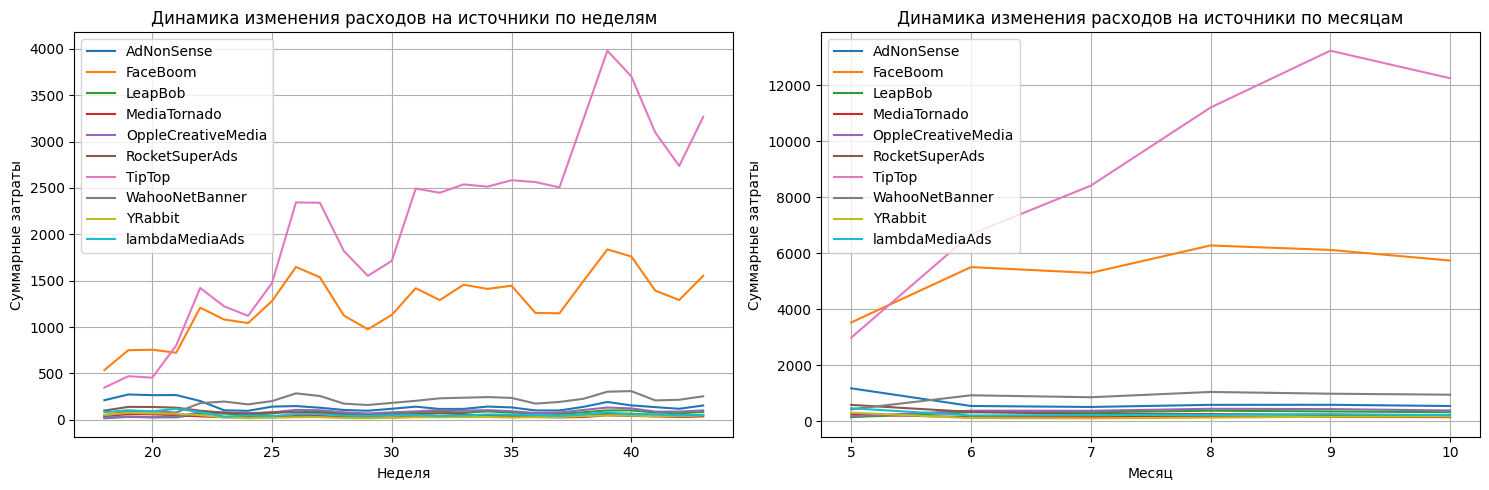

In [36]:
plt.figure(figsize = (15,5))
#график 1
ax1 = plt.subplot(1,2,1)
ad_costs_pivot = ad_costs.pivot_table(index='dt_week', columns = 'channel', values = 'costs', aggfunc='sum')
ad_costs_pivot.plot(grid=True, ax = ax1)
plt.legend()
plt.xlabel('Неделя')
plt.ylabel('Суммарные затраты')
plt.title('Динамика изменения расходов на источники по неделям')

#график 2
ax2 = plt.subplot(1,2,2)
ad_costs_pivot = ad_costs.pivot_table(index='dt_month', columns = 'channel', values = 'costs', aggfunc='sum')
ad_costs_pivot.plot(grid=True, ax = ax2)
plt.legend()
plt.xlabel('Месяц')
plt.ylabel('Суммарные затраты')
plt.title('Динамика изменения расходов на источники по месяцам')

plt.tight_layout()
plt.show()

Графики показывают нам, что расходы на рекламу у источников *FaceBoom* и *TipTop* самые высокие и стабильно растут по неделям и месяцам.

### Стоимость привлечения одного пользователя (CAC) с разбивкой по каналам привлечения.

In [37]:
print(
    profiles.groupby('channel')
    .agg({'acquisition_cost':'mean'})
    .sort_values(by='acquisition_cost', ascending=False)
)   

                    acquisition_cost
channel                             
TipTop                      2.799003
FaceBoom                    1.113286
AdNonSense                  1.008054
lambdaMediaAds              0.724802
WahooNetBanner              0.602245
RocketSuperAds              0.412095
OppleCreativeMedia          0.250000
YRabbit                     0.218975
MediaTornado                0.218717
LeapBob                     0.210172
organic                     0.000000


Самый высокий показатель CAC - у канала *TipTop* (целых 2.79 долларов), за ним следует *FaceBoom* и *AdNonSense* со значениями 1.11 и 1 долларов.
Самый низкий CAC - у канала *LeapBob* - всего 0.21 доллара..
_______
Пока что ситуация выглядит так, что у канала TipTop - слишком высокая стоимость привлечения клиентов относительно его эффективности. Но эта гипотеза требует подтверждения. На следующем этапе будем выяснять, окупается ли реклама у этих и других каналов.

## Оценка окупаемости рекламы

Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы. Также оценим конверсию и удержание пользователей.

### Общая окупаемость рекламы (LTV, ROI, CAC и их динамика).

Зададим момент анализа как 1 ноября 2019 года. В бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Поэтому установим горизонт анализа в 14 дней. Также уберем пользователей, привлеченных органическим методом, так как нас прежде всего интересует окупаемость рекламных источников.

In [38]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа

horizon_days = 14  # горизонт анализа 

ad_profiles = profiles.query('channel != "organic"') # уберем органических пользователей

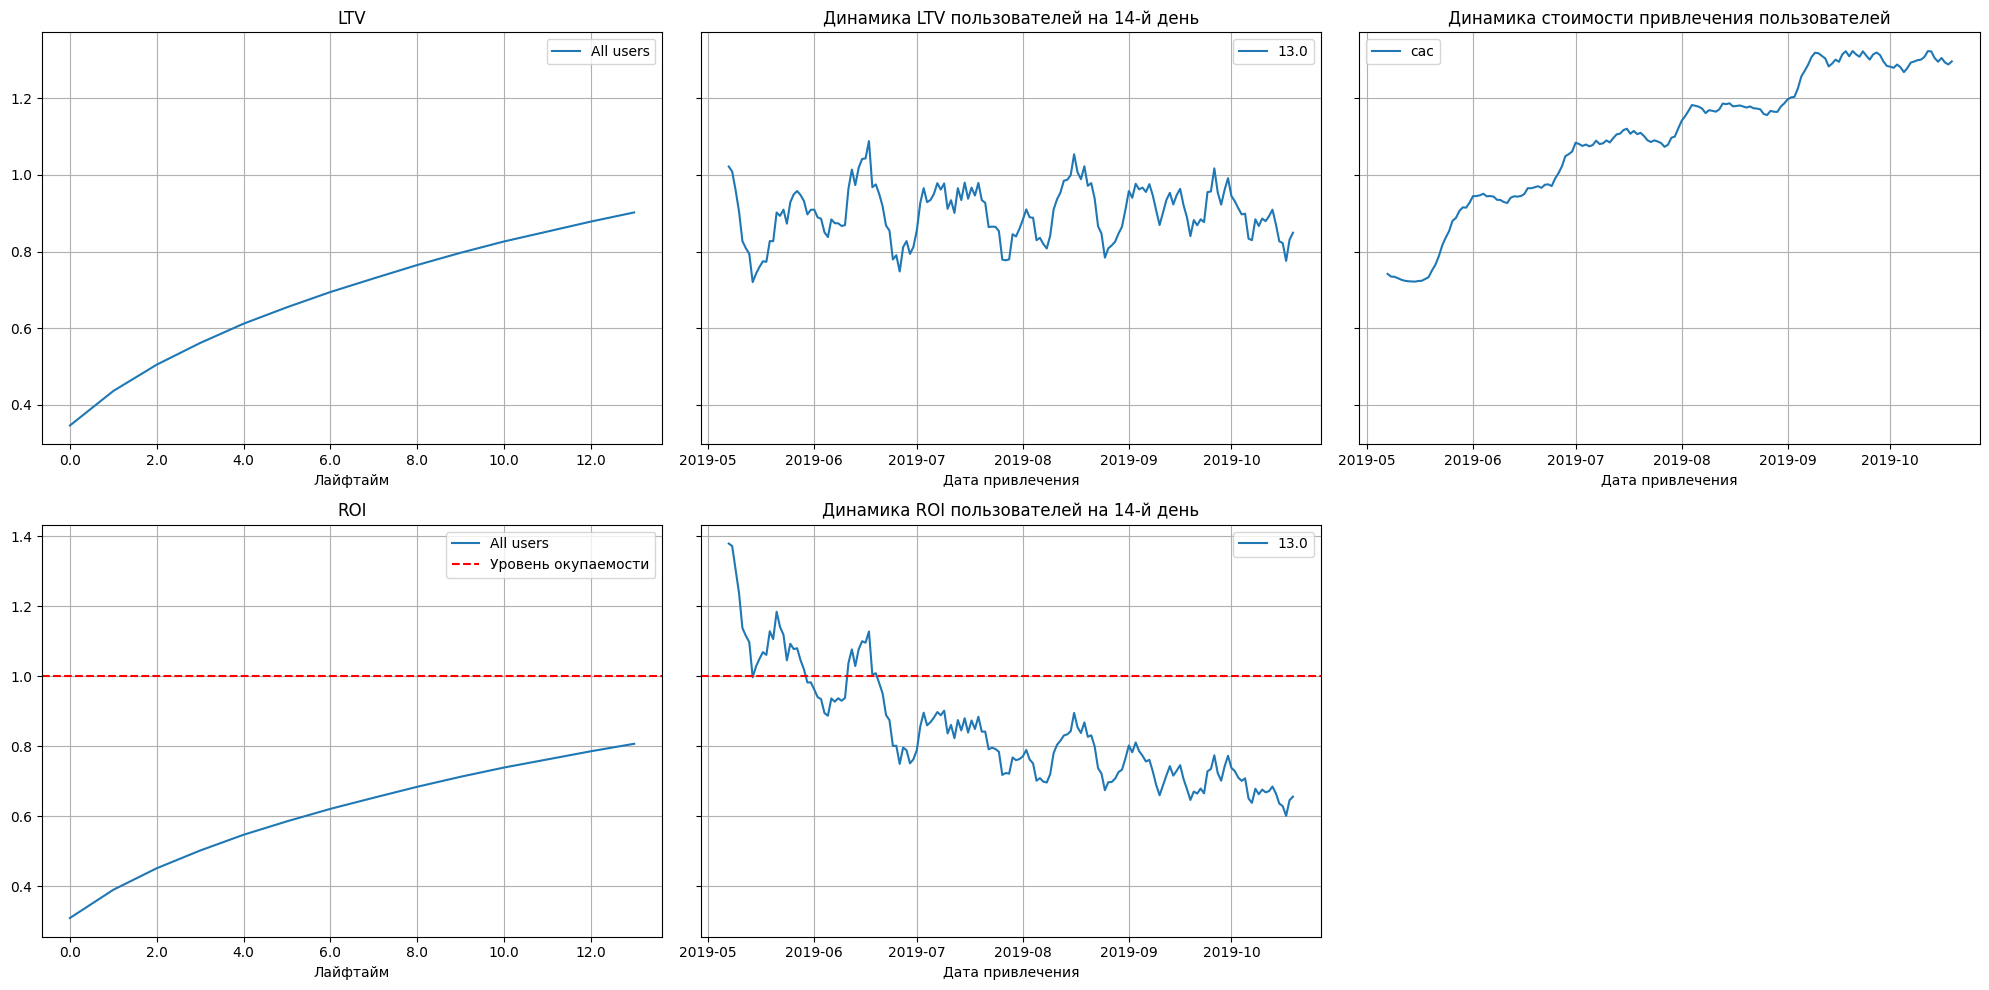

In [39]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    ad_profiles, orders, observation_date, horizon_days
)
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

- LTV растет с увеличением лайфтайма, ROI тоже, однако показатель ROI к концу 2-недельного лайфтайма еле достиг отметки в 80% - следовательно общие затраты на рекламу не окупаются. 
- Показатель расходов на привлечение одного пользователя (CAC) вырос почти в два раза с мая по конец октября - с 0.7 до почти 1.4 доллара. 
- Динамика ROI также показывает ухудшение с течением времени: если в мае и июне реклама еще окупала себя частично, то после июня дела стали совсем плохи. К октябрю окупаемость упала до отметки около 65%.

### Конверсия и удержание пользователей в целом

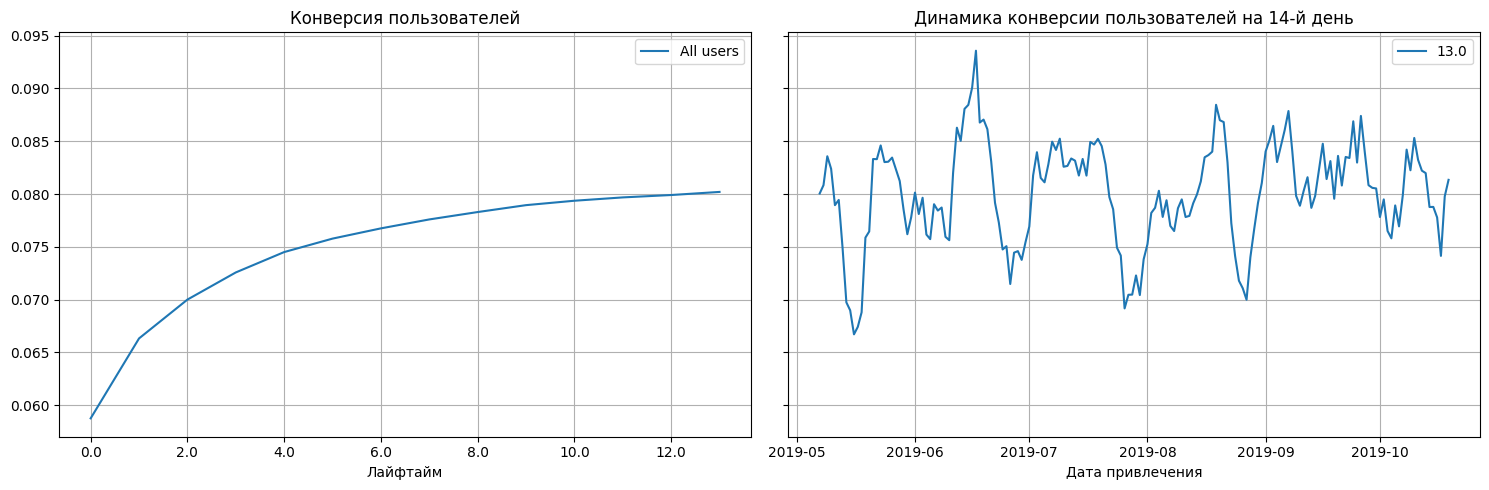

In [40]:
# считаем конверсию
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    ad_profiles, orders, observation_date, horizon_days
)

# строим графики
plot_conversion(conversion_grouped, conversion_history, horizon_days)  

- Общая конверсия растет с увеличением лайфтайма, как и должно быть. Пользователи конвертируются стабильно. На 1-й день жизни конверсия составляет почти 6%.
- Динамика конверсии на 14-й день жизни пользователя показывает, что средняя конверсия с мая по октябрь практически не изменилась. 
- Также можно отметить волнообразный характер динамики этого показателя. Возможно, на это влияют сезонные события.

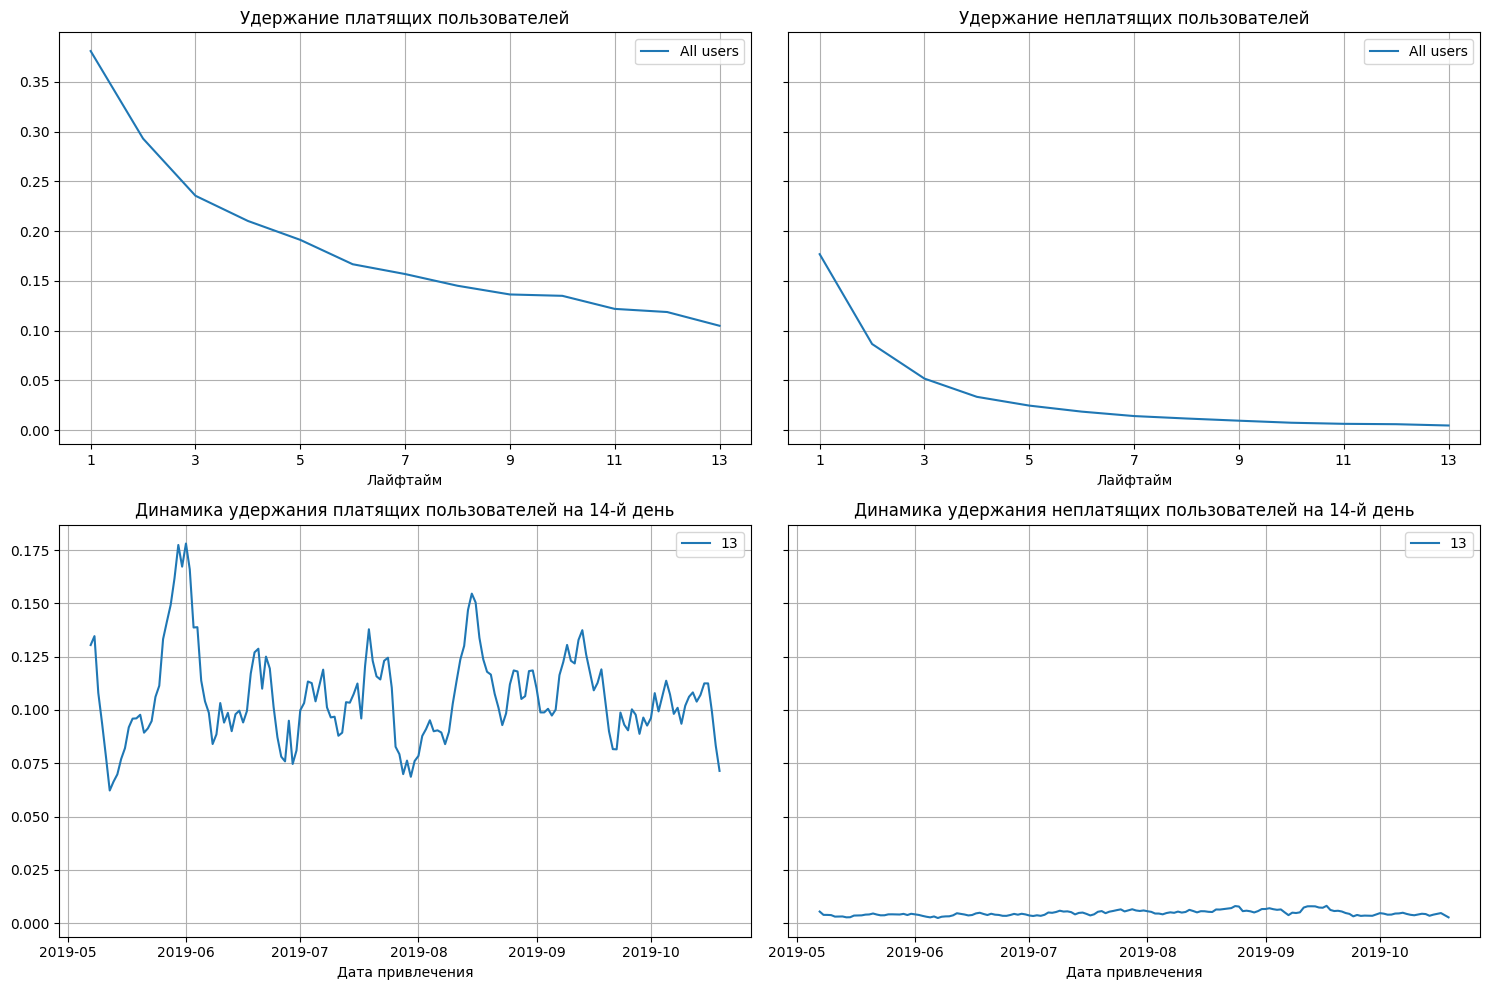

In [41]:
# считаем удержание
retention_raw, retention_grouped, retention_history = get_retention(
    ad_profiles, visits, observation_date, horizon_days
)

# строим графики
plot_retention(retention_grouped, retention_history, horizon_days) 

- Визуализация удержания и динамики удержания показывает, что удержание платящих пользователей ожидаемо выше чем у неплатящих.
- К концу двухнедельного лайфтайма около 10% платящих клиентов остаются пользователями приложения, в то время как у неплатящих этот показатель близок к 0%.
- Динамика удержания платящих пользователей показывает незначительное, но заметное ухудшение с мая по октябрь: с отметки около 13% показатель приблизился к 7.5%.
- Динамика удержания неплатящих пользователей с двухнедельным лайфтаймом находится на стабильно низком уровне - меньше 2.5%.

### Конверсия и удержание пользователей с разбивкой по разным показателям.

#### По типу устройства

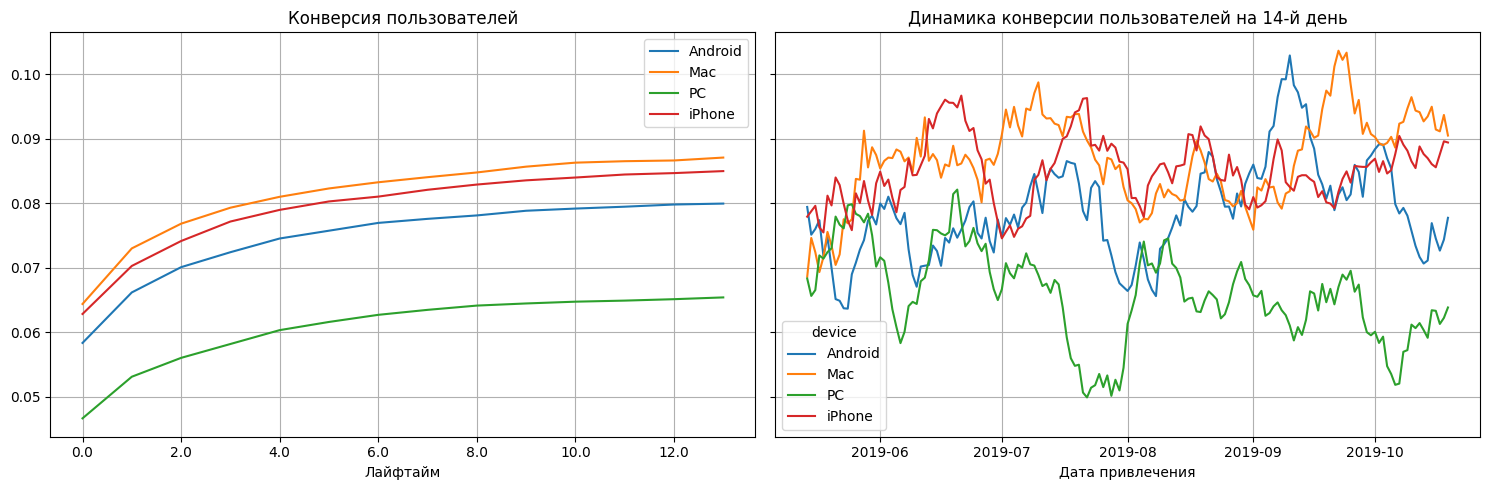

In [42]:
# смотрим конверсию с разбивкой по устройствам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    ad_profiles, orders, observation_date, horizon_days, dimensions = ['device']
)

# строим графики
plot_conversion(conversion_grouped, conversion_history, horizon_days, window = 14) 

- Конверсия стабильно растет у всех типов устройств, правда у пользователей PC она находится на самом низком уровне.
- Заметна  просадка в уровне конверсии с июля по август для пользователей PC.

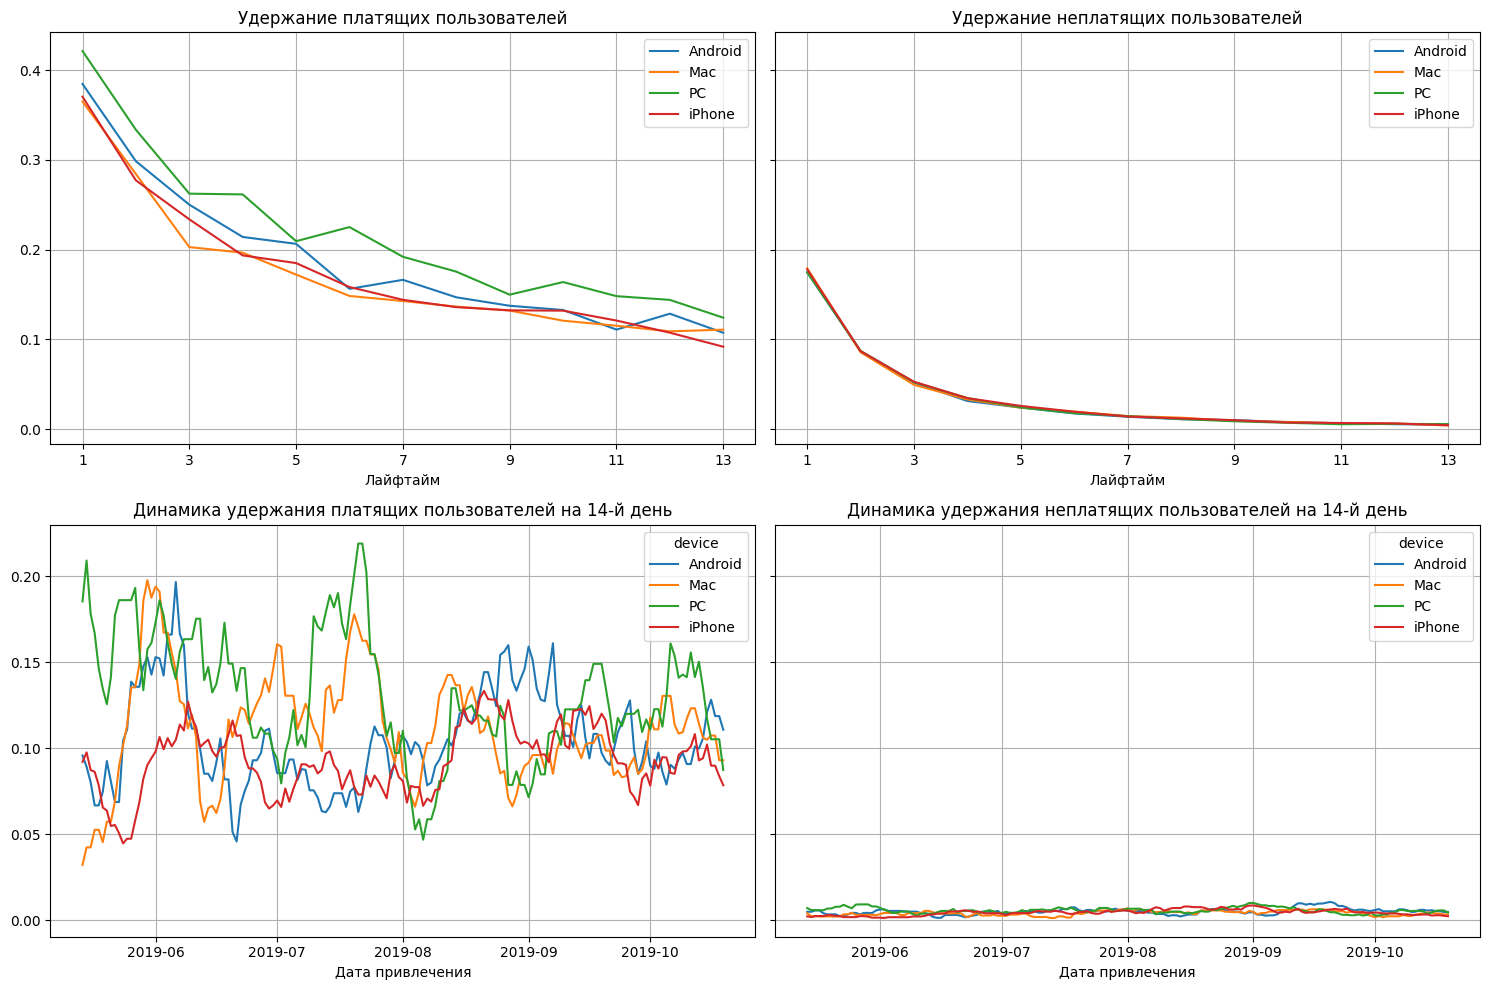

In [43]:
# вычислчяем удержание с разбивкой по каналам
retention_raw, retention_grouped, retention_history = get_retention(
    ad_profiles, visits, observation_date, horizon_days, dimensions=['device']
)

# строим графики
plot_retention(retention_grouped, retention_history, horizon_days, window = 14) 

- Несмотря на хорошие показатели конверсии, пользователи iPhone и Mac удерживаются хуже остальных.
- Лучше всех остальных удерживаются пользователи PC.
- Удержание неплатящих пользователей ожидаемо ниже чем у платящих.

#### По стране

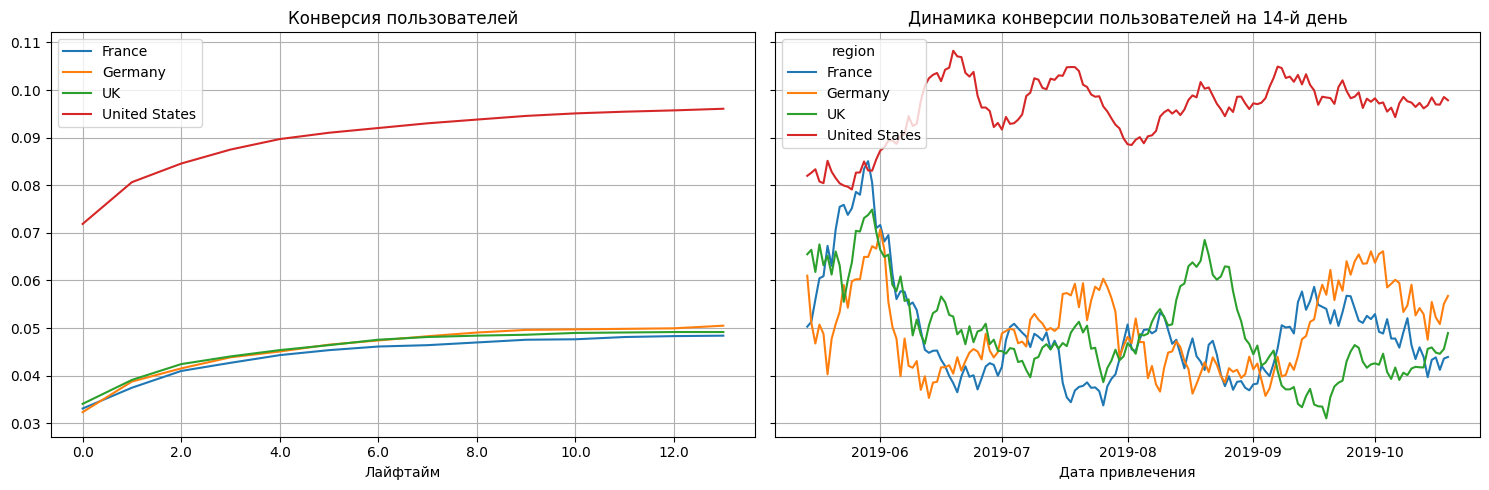

In [44]:
# смотрим конверсию с разбивкой по странам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    ad_profiles, orders, observation_date, horizon_days, dimensions = ['region']
)

# строим графики
plot_conversion(conversion_grouped, conversion_history, horizon_days, window = 14) 

- Конверсия пользователей из США имеют отличную конверсию по сравнению с другими странами.
- Конверсия пользователей из США с первого дня жизни на 0.4 пункта выше, чем у других стран.

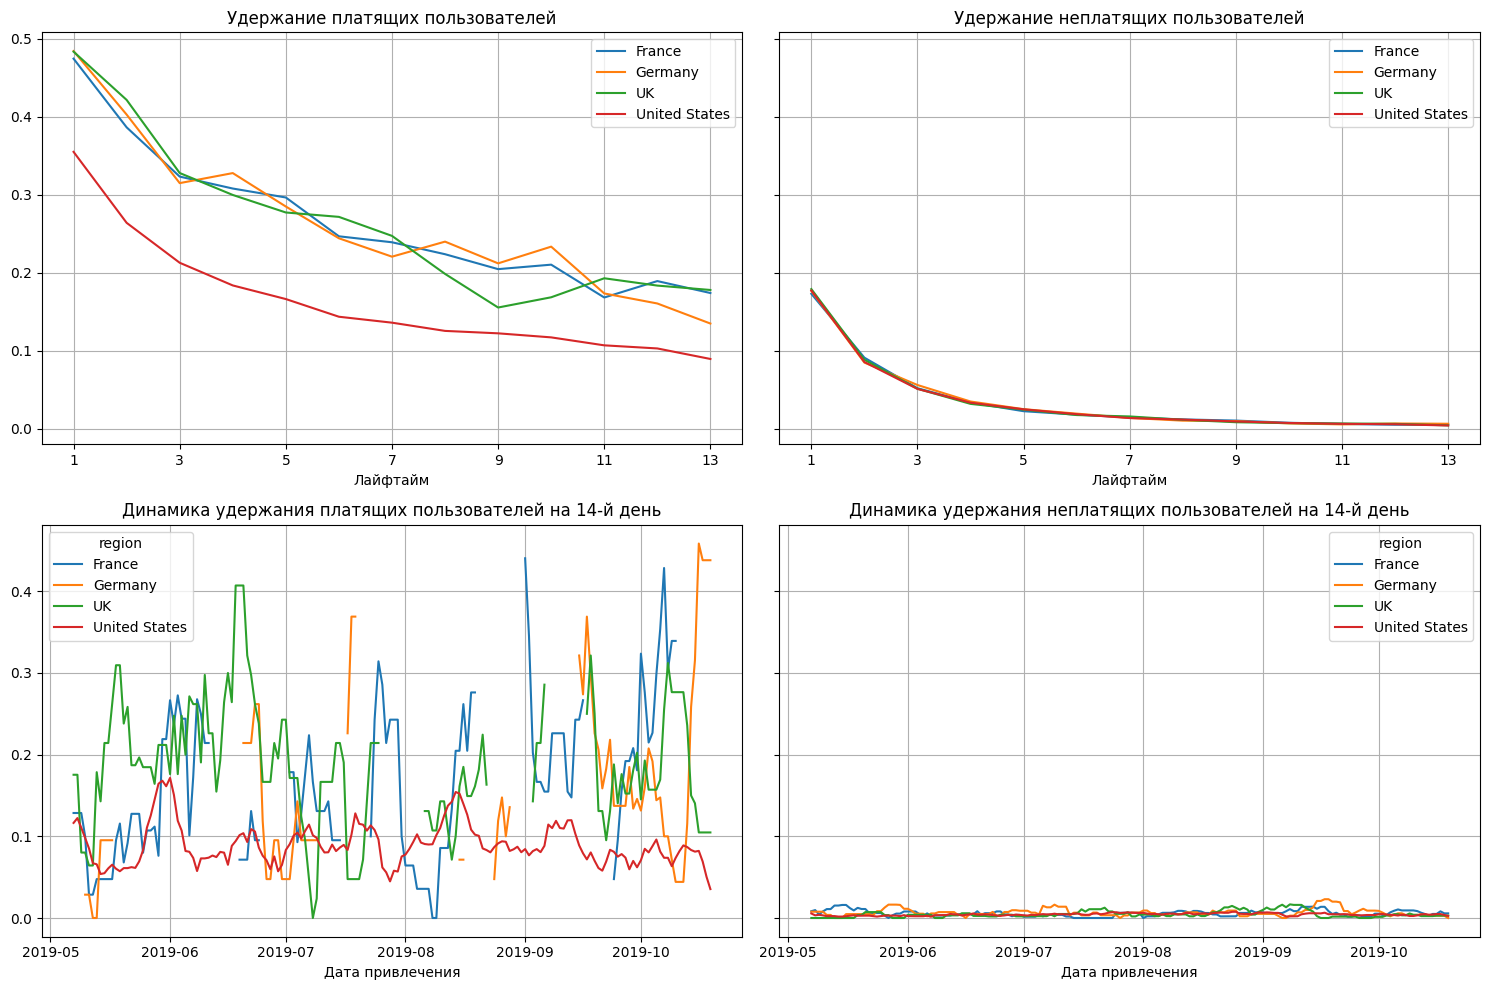

In [45]:
# считаем удержание с разбивкой по странам
retention_raw, retention_grouped, retention_history = get_retention(
    ad_profiles, visits, observation_date, horizon_days, dimensions=['region']
)

# строим графики
plot_retention(retention_grouped, retention_history, horizon_days) 

- Несмотря на отличную конверсию, у пользователей из США очень слабое удержание относительно других стран.
- Проблемы с удержанием наблюдаются с первого же дня жизни - возможно, есть какие-то проблемы на первых шагах взаимодействия пользователя с платформой.
- У остальных стран удержание планомерно падает с небольшими различиями.

#### По каналам привлечения

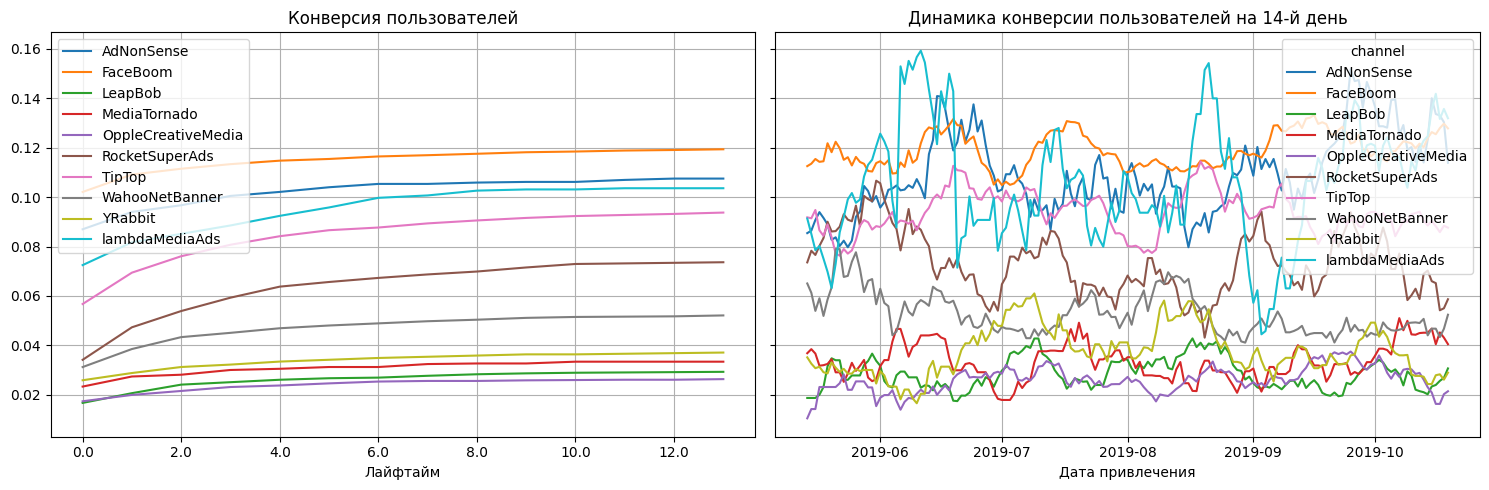

In [46]:
# считаем конверсию с разбивкой по каналам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    ad_profiles, orders, observation_date, horizon_days, dimensions = ['channel']
)

# строим графики
plot_conversion(conversion_grouped, conversion_history, horizon_days, window = 14) 

- Самая высокая конверсия наблюдается у пользователей, привлеченных через канал *FaceBoom*.
- На втором месте находится канал *AdNonSense*.
- Самые низкие показатели - у *LeapBob* и *OppleCreativeMedia*.
____
Стоит взглянуть на их показатели удержания

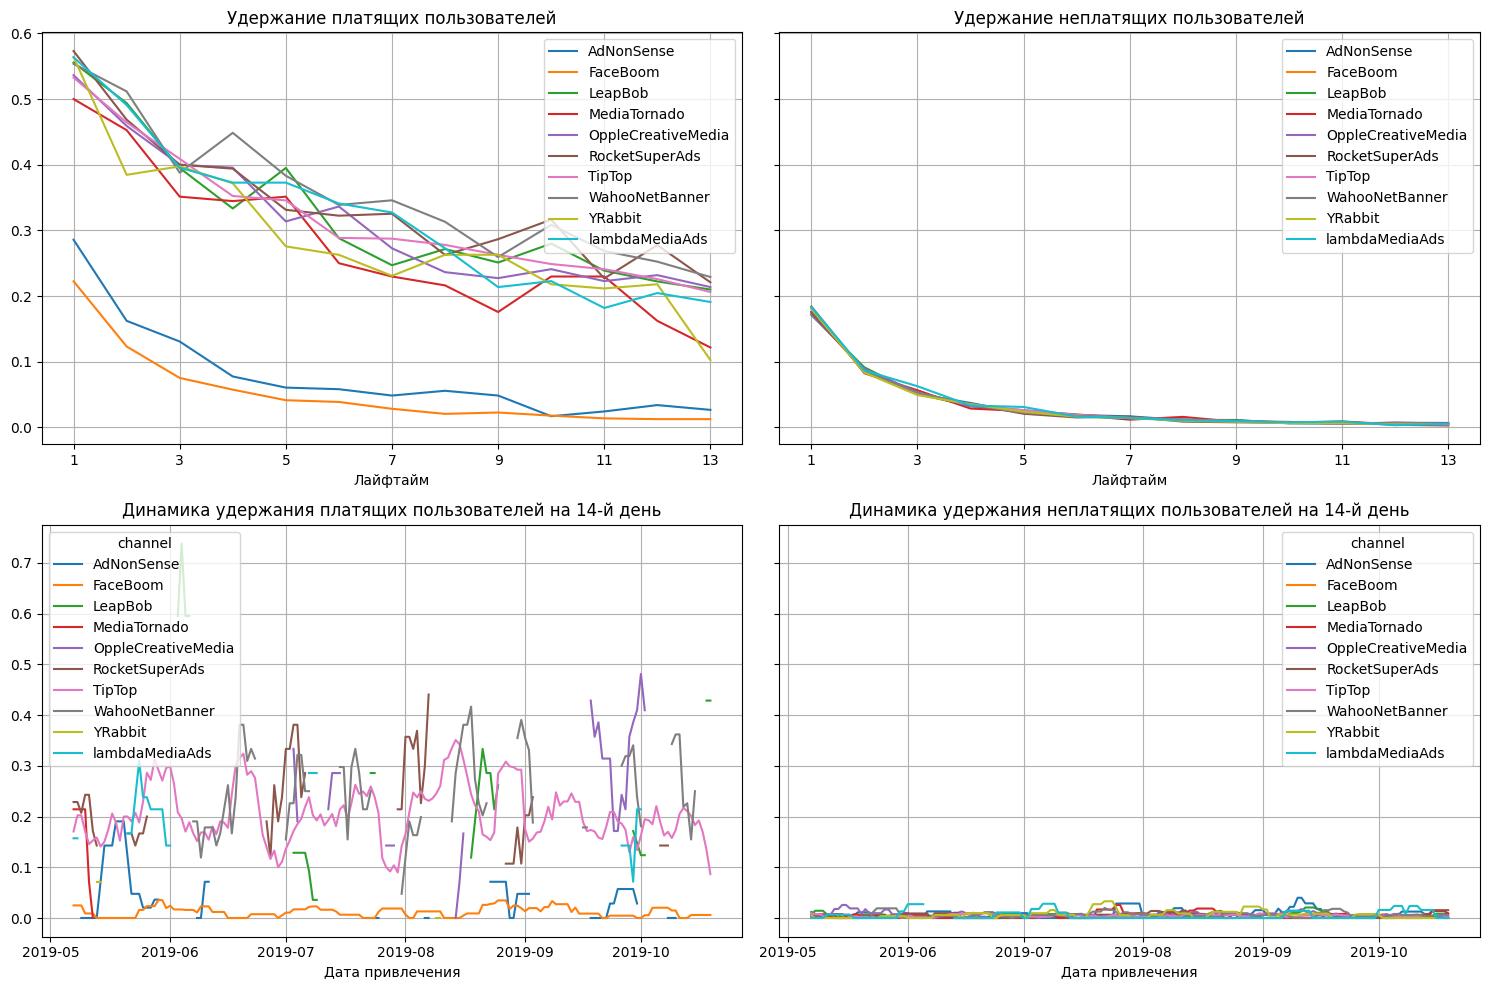

In [47]:
# считаем удержание с разбивкой по каналам
retention_raw, retention_grouped, retention_history = get_retention(
    ad_profiles, visits, observation_date, horizon_days, dimensions=['channel']
)

# строим графики
plot_retention(retention_grouped, retention_history, horizon_days)

- У лидеров по конверсии наблюдаются худшие результаты удержания.
- С первого же дня удержание у них находится между 20 и 30%, в то время как остальные каналы показывают результаты от 50 до 60%.

### Окупаемость привлечения пользователей с разбивкой по типу используемого устройства.

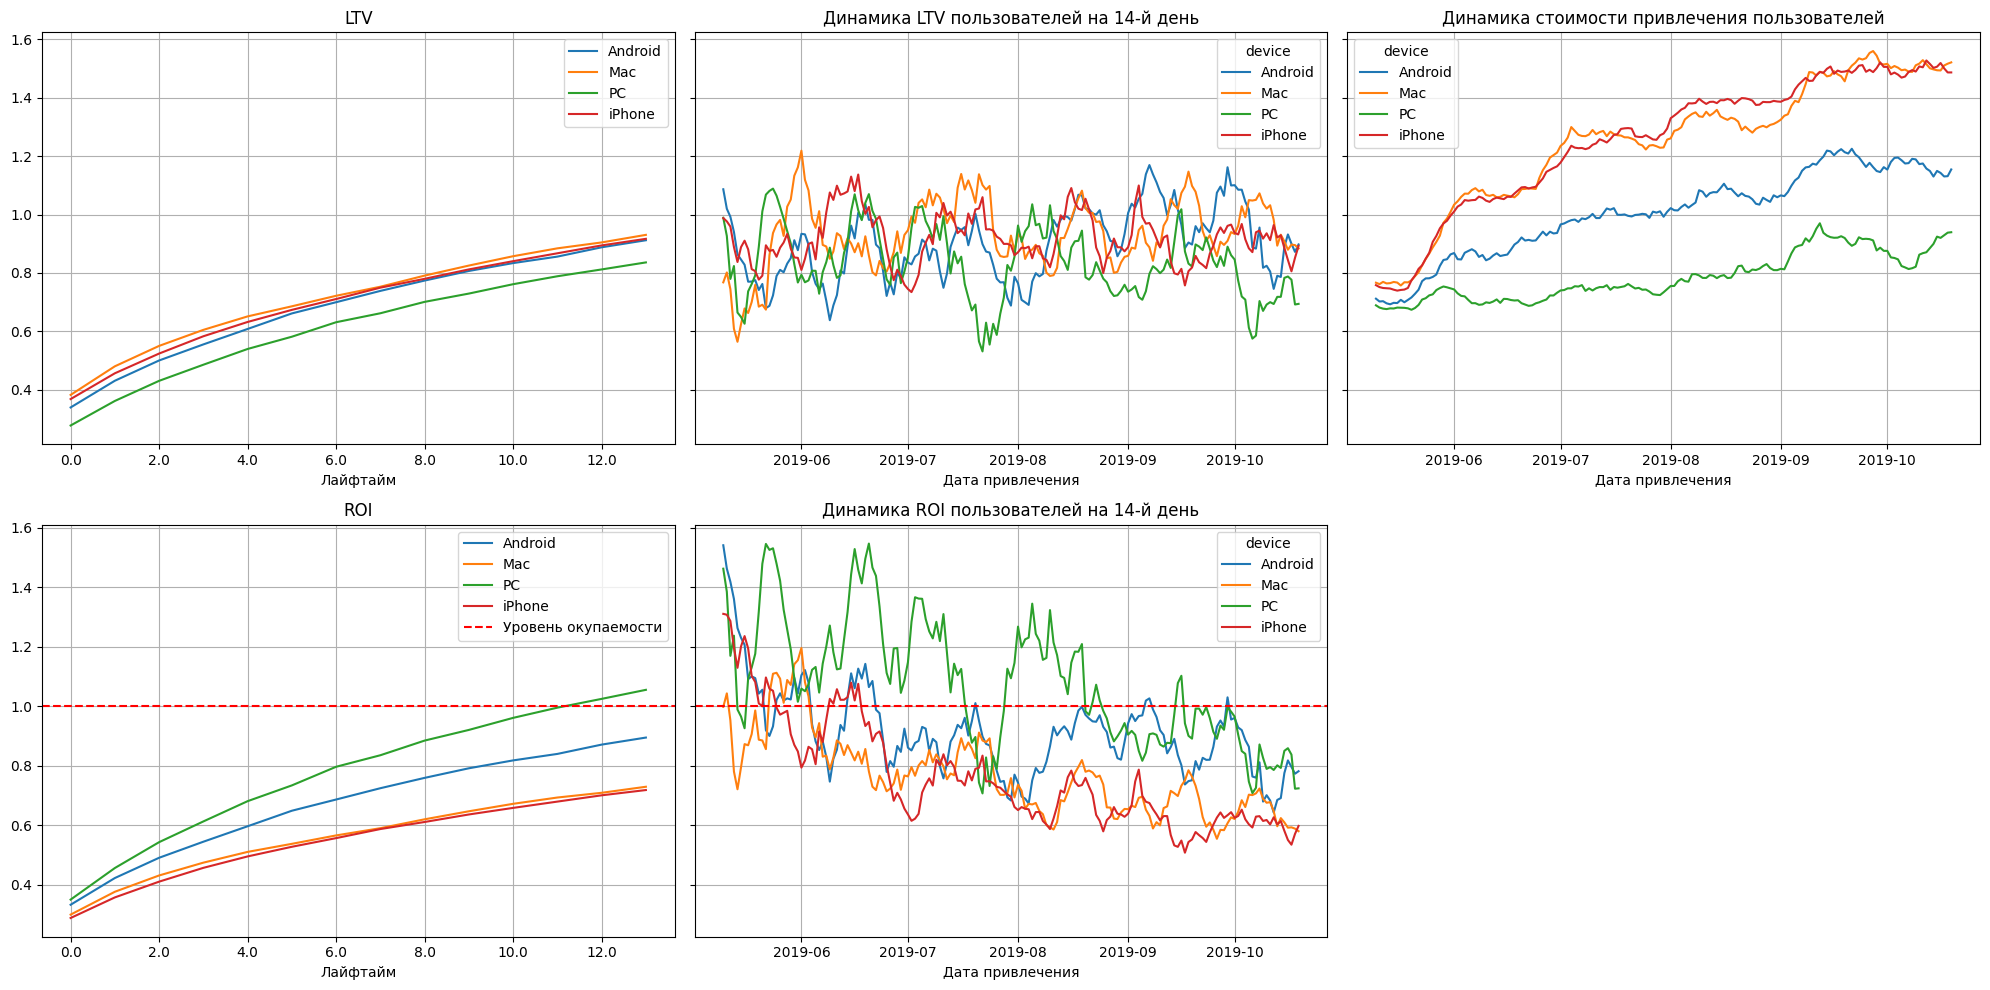

In [48]:
# считаем LTV и ROI с разбивкой по типам устройств
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    ad_profiles, orders, observation_date, horizon_days, dimensions=['device']
)
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window = 10) 

- Только у пользоваталей PC к концу рассматриваемого периода окупаемость превысила 100%.
- У пользователей айфонов и макбуков худшая окупаемость - к концу двухнедельного лайфтайма она составила около 70% от затраченных средств.
- Стоимость привлечения пользоваталей PC по сравнению с пользователями других устройств выросла меньше всего. 
- LTV в разбивке по устройствам по-прежнему достаточно стабилен. 
- Значит, дело не в ухудшении качества пользователей какой-то отдельной группы устройств.

### Окупаемость привлечения пользователей с разбивкой по странам.

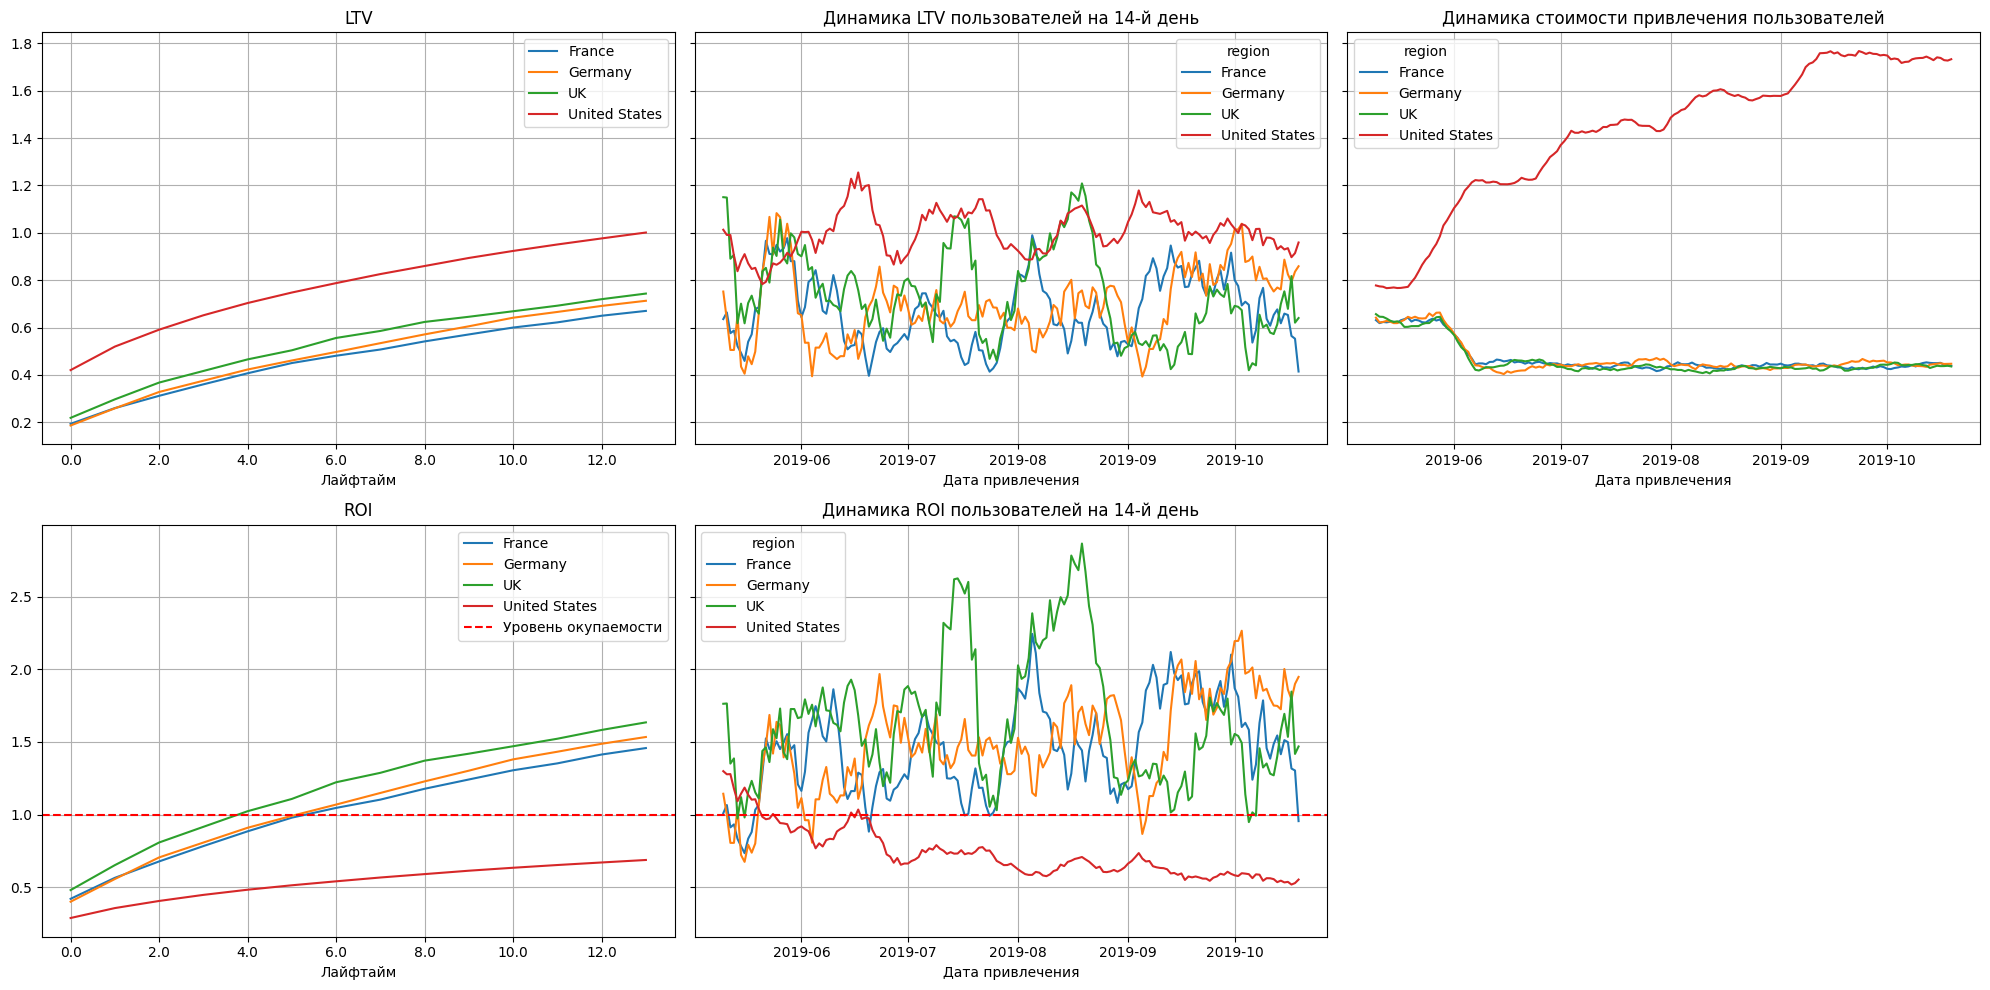

In [49]:
# считаем LTV и ROI с разбивкой по типам устройств
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    ad_profiles, orders, observation_date, horizon_days, dimensions=['region']
)
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window = 10) 

- С получением этих данных мы возможно приблизились к разгадке плохой общей окупаемости.
- Пользователи из всех стран кроме США хорошо окупаются - их показатели находятся в районе 150% окупаемости, в то время как у пользователей из США показатель ROI находится на уровне около 70%. 
- Стоимость привлечения пользователей из США стала резко расти в июне, в то время как у других стран стоимость снизилась и осталась на стабильном уровне с июня по октябрь.
- Стоимость привлечения пользователей из США с мая по октябрь увеличилась более чем в 2 раза - с 0.8 до почти 1.8 доллара за привлеченного пользователя.
- Как мы помним, пользователи из США составляют основную массу пользователей сервиса - также среди них наивысший % покупателей.
_____
Считаю, что дальше нужно исследовать каналы привлечения отдельно из США и из других стран.

### Окупаемость привлечения пользователей из США с разбивкой по источникам привлечения.

In [50]:
# отфильтруем ранее созданный датафрейм, оставив только пользователей и каналы из США

usa_ad_profiles = ad_profiles.query('region == "United States"') 

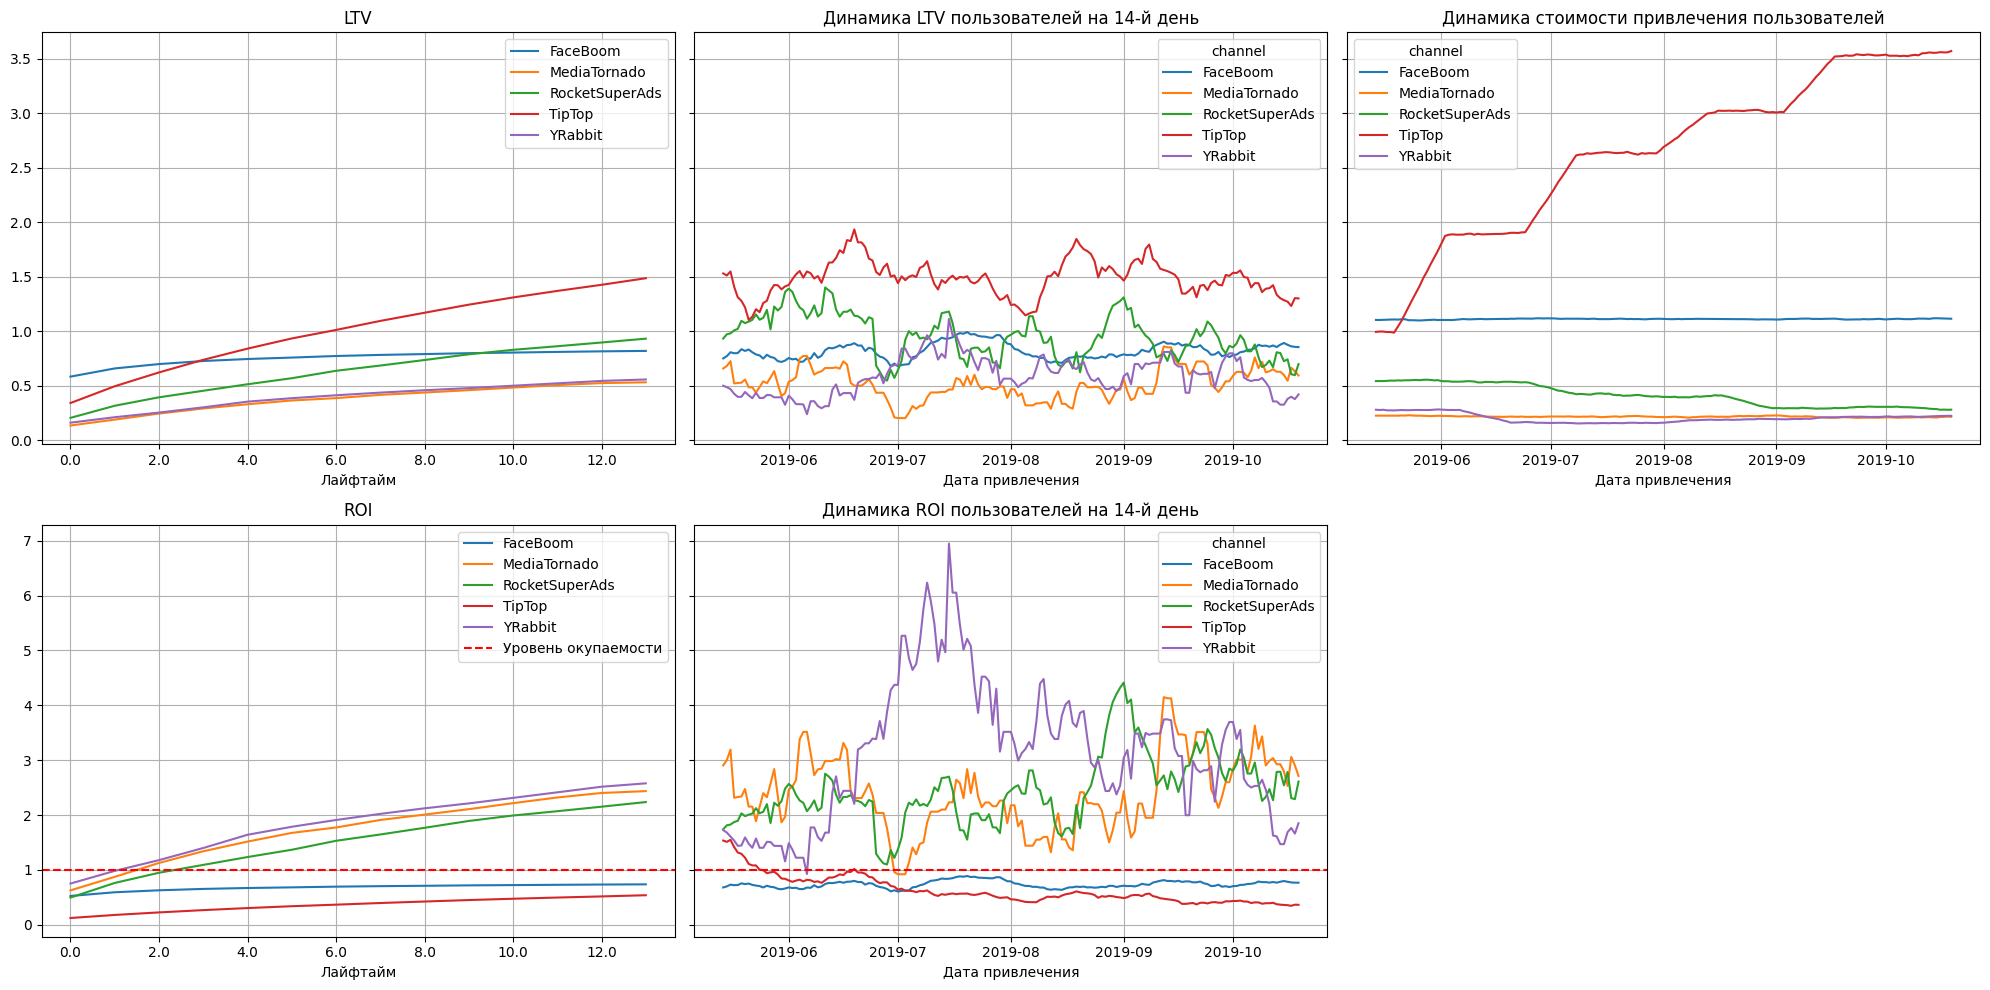

In [51]:
# считаем LTV и ROI с разбивкой по каналам привлечения
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    usa_ad_profiles, orders, observation_date, horizon_days, dimensions=['channel']
)
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window = 14) 

Для пользователей и каналов из США следующие результаты:
- LTV пользователей с разбивкой по каналам стабильно растет, и лучше всего растет для канала привлечения *TipTop*.
- Это не отменяет того факта, что у каналов *TipTop* и *FaceBoom* не окупается реклама. И там, и там показатель меньше 100% - где-то на уровне между 70 и 90%.
- Стоимость привлечения через канал *TipTop* растет не по дням конечно, но по месяцам - каждый месяц происходит значительный скачок стиоимости. В итоге с мая по октябрь стоимость выросла с 1 доллара до 3.5 - в 3.5 раза!
- Стоимость привлечения через канал *FaceBoom* не растет, но находится на стабильно высоком уровне для того, чтобы начать окупаться.
- У всех остальных каналов хорошие показатели ROI - выше 200%. Также стоимость привлечения пользователей находится на стабильно низком уровне, а у некоторых даже снижается.

### Окупаемость привлечения пользователей из других стран с разбивкой по источникам привлечения.

In [52]:
# отфильтруем ранее созданный датафрейм, оставив только пользователей не из США

eu_ad_profiles = ad_profiles.query('region != "United States"') 

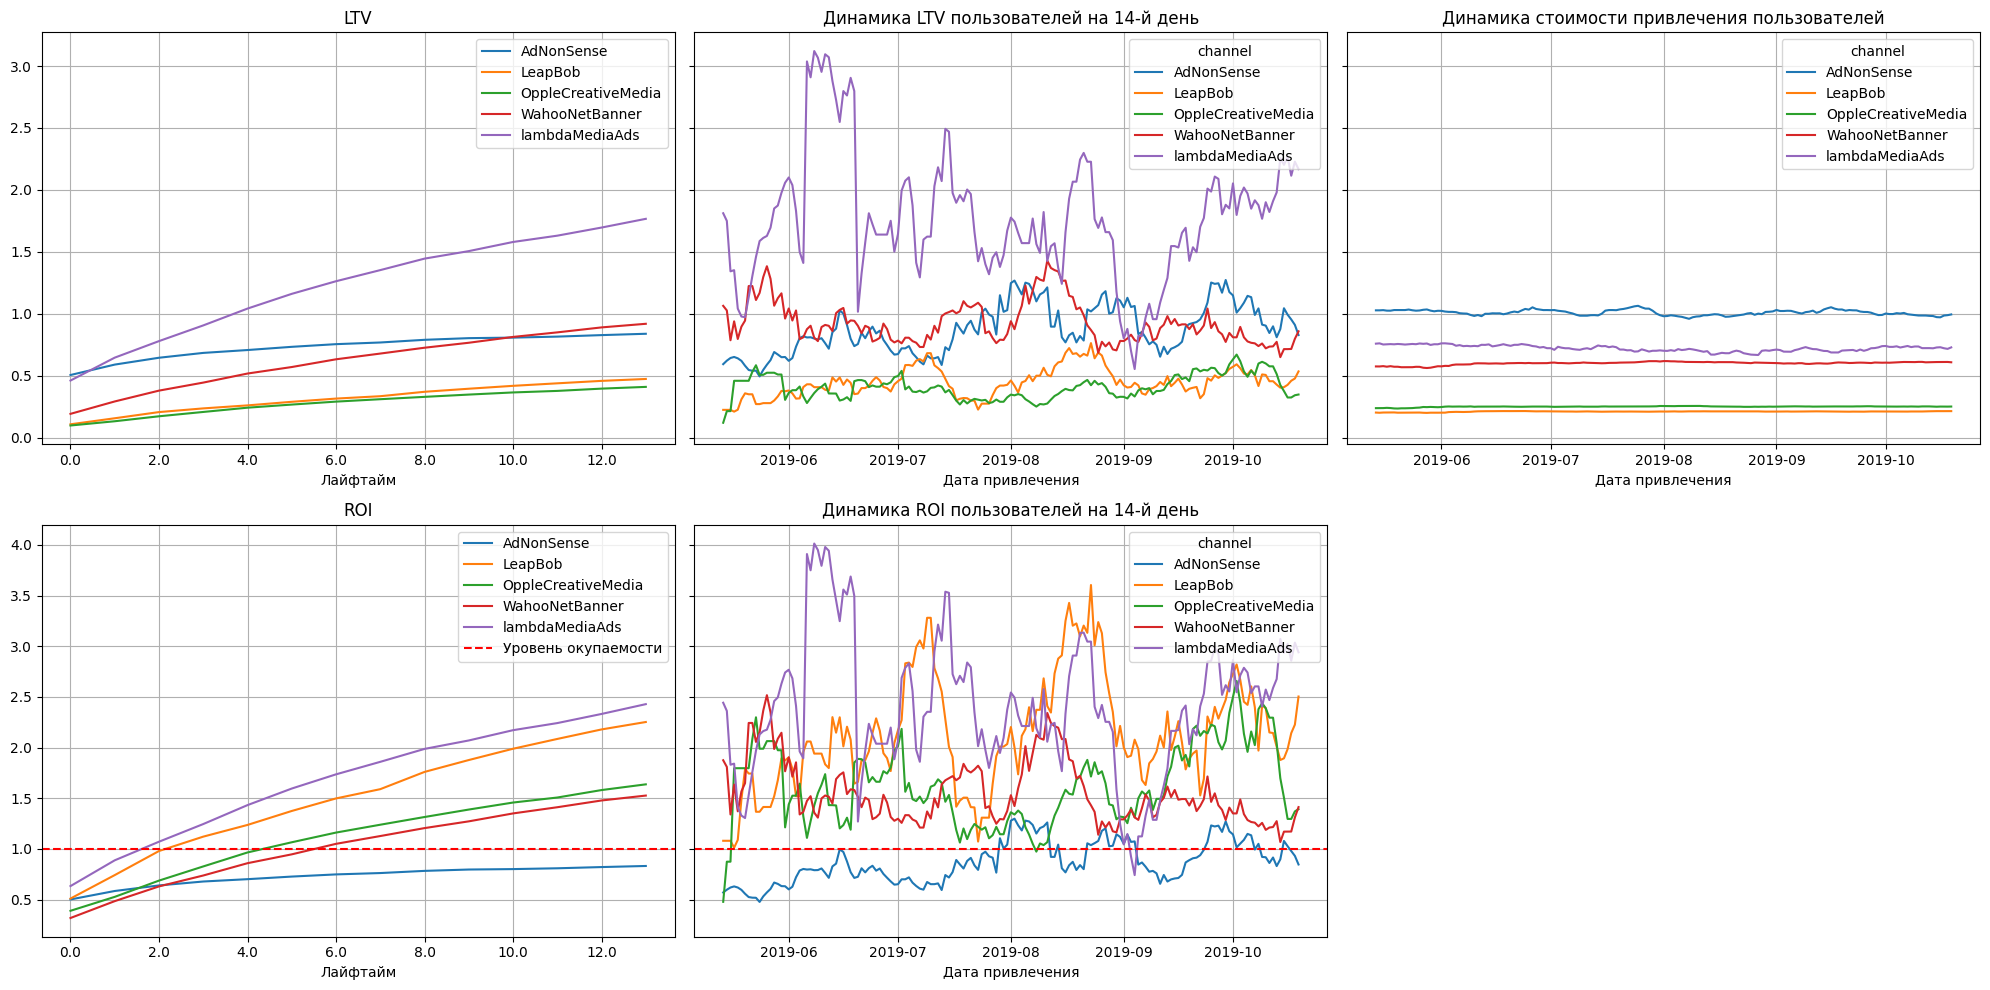

In [53]:
# считаем LTV и ROI с разбивкой по каналам привлечения
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    eu_ad_profiles, orders, observation_date, horizon_days, dimensions=['channel']
)
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window = 14) 

Для пользователей и каналов из Европы следующие результаты:
- Окупилась реклама всех каналов, кроме *AdNonSense*. Для этого канала ROI к концу двухнедельного лайфтайма составил около 80%.
- *lambdaMediaAds* показывает лучшие значения окупаемости и LTV - при этом значения стоимости привлечения одного пользователя держатся на уровне около 0.7 доллара.
- У канала *LeapBob* самое низкое значение CAC  и при этом хорошая окупаемость - на втором месте после *lambdaMediaAds*.

### Вывод по пункту 5
- Реклама, направленная на привлечение пользователей, не окупается в целом.
- По типам устройств окупаются лишь пользователи PC. Стоит поработать над конверсией этих пользователей, так как она находится на низком уровне относительно других групп.
- Пользователи из США составляют основу клиентов сервиса, однако наблюдается низкий уровень удержания данных пользователей с 1-го дня жизни. Стоит изучить возможные проблемы взаимодействия пользователей с платформой.
- По каналам привлечения есть 2 убыточных канала для США и 1 убыточный канал для Европы: *TipTop* и *FaceBoom* для США и *AdNonSense* для Европы. 
- У канала *TipTop* слишком высокий рост стоимости привлечения. Стоит задуматься о продолжении сотрудничества с ними и другими убыточными каналами.
- Стоит присмотреться к более тесному сотрудничеству с такими каналами, как *MediaTornado, LeapBob, LambdaMediaAds и RocketSuperAds* - у них отличные показатели окупаемости и динамики стоимости привлечения.


## Выводы по итогам исследования.

Чтобы разобраться в причинах убытков компании и помочь ей выйти в плюс, мы провели исследовательский анализ данных о посещениях сайта, заказах и расходах на рекламу. Изучив поведение пользоваталей, привлеченных с 1 мая 2019 года по 27 октября 2019 года, сделали следующие наблюдения: 
- Общие затраты на рекламу составили **105497$**.
- Пользователи приложения представлены 4-мя странами: США, Германия, Франция и Великобритания.
- Источники привлечения представлены десятью компаниями: 5 из них приходится на США,  5 на остальные страны.
- Больше всего пользователей приложения проживают в США. Эта же страна лидирует по количеству привлеченных покупателей. У пользователей из США отличные показатели конверсии, но при этом ужасные показатели удержания. Затраты на рекламу для привлечения пользователей из США не окупаются, в отличие от других представленных стран: **Германии, Франции и Великобритании**. Возможно, есть проблемы на начальных этапах взаимодействия пользователей из США с приложением - стоит обратиться к техническому отделу.
- Наибольшее количество покупателей пользуются **Mac и iPhone**. У них хорошая конверсия, однако удержание оставляет желать лучшего. Опять же стоит проработать взаимодействие пользователей этими устройствами с приложением.
- Среди неорганических источников канал **'FaceBoom'** находится на первом месте по количеству привлеченных пользователей и покупателей, однако он имеет ужасный уровень показателя удержания. Схожая проблема актуальна для 'AdNonSense' - они вторые по количеству привлеченных пользователей и покупателей, но тоже имеют ужасный показатель удержания. Оба этих источника привлечения не  окупаются, хоть и имеют сравнительно невысокую стоимость привлечения клиента, поэтому стоит попробовать разобраться в причине такого низкого уровня удержания. 
- У канала 'TipTop' (США) огромная стоимость привлечения относительно других каналов, при этом он находится на 4-м месте по привлечению новых покупателей. Данный источник привлечения не окупается и дальнейшее сотрудничество с ним приведет к еще большим убыткам для компании.

Я бы рекомендовал отделу маркетинга обратить внимание на убыточные каналы привлечения и сократить с ними сотрудничество, также как усилить сотрудничество с каналами с хорошей окупаемостью. Также стоит обратиться к техническому отделу для выявления возможных проблем взаимодействия пользователей из США, а также пользователей Mac и iPhone. Не лишним будет продумать стратегию привлечения большего количества покупателей среди пользователей PC, например введения новых функций или скидок для данной группы пользователей.


